# Subset Selection

Source: www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf

In [1]:
import pandas as pd 
import numpy as np 
import itertools 
import time 
import statsmodels.api as sm 
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
df = pd.read_csv("./hitters.csv")
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [3]:
# salary variable is missing for some players
print(df["Salary"].isnull().sum())

59


In [4]:
print(df.shape)

(322, 21)


In [6]:
# drop any rowns missing values
df = df.dropna().drop("Unnamed: 0", axis=1)
print(df.shape)

(263, 20)


In [7]:
print(df["Salary"].isnull().sum())

0


In [8]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df.Salary

# drop the column with the independent variable (Salary) and columsn for which we created dummy variables for
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64') 

X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

### Subset

Next we create a function to perform subset selection by identifying the best model  given a number of predictors. 

"best" is quantified using __RSS__

In [14]:
def processSubset(feature_set):
    # Fit modle on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y ) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [10]:
def getBest(k):
    tic = time.time()
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
        
    models = pd.DataFrame(results)
    
    ## choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [15]:
models = pd.DataFrame(columns = ["RSS", "model"])

tic = time.time()
for i in range(1, 8):
    models.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")


/home/redne/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  # This is added back by InteractiveShellApp.init_path()


Processed  19 models on 1 predictors in 0.0774223804473877 seconds.
Processed  171 models on 2 predictors in 0.5898184776306152 seconds.
Processed  969 models on 3 predictors in 3.3650355339050293 seconds.
Processed  3876 models on 4 predictors in 13.658149242401123 seconds.
Processed  11628 models on 5 predictors in 41.68551540374756 seconds.
Processed  27132 models on 6 predictors in 98.68887066841125 seconds.


KeyboardInterrupt: 

In [16]:
# print the best 2 model
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Sun, 19 May 2019   Prob (F-statistic):           5.80e-82
Time:                        17:47:32   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

In [17]:
models.loc[2, "model"].rsquared

0.7614950002332872

__Pull out all of the $R^2$ attributes__

In [19]:
models. apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
dtype: float64

In [24]:
models.head()

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...


Text(0, 0.5, 'RSS')

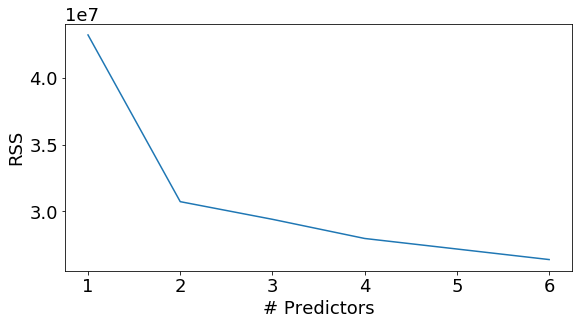

In [23]:
plt.figure(figsize=(20,10)) 
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
plt.subplot(2, 2, 1)
            
plt.plot(models["RSS"]) 
plt.xlabel('# Predictors')
plt.ylabel('RSS')


# Forward Selection

In [35]:
def forward(predictors):
    
    # pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
        
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), " second.")
    
    # Return the best model, along with some other useful information about the model 
    return best_model


In [36]:
models2 = pd.DataFrame(columns=["RSS", "model"])


In [37]:
tic = time.time()
predictors = []

for i in range(1, len(X.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time: ", (toc-tic), " seconds.")

/home/redne/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  from ipykernel import kernelapp as app


Processed  19 models on 1 predictors in 0.08185291290283203  second.
Processed  18 models on 2 predictors in 0.06274008750915527  second.
Processed  17 models on 3 predictors in 0.058904409408569336  second.
Processed  16 models on 4 predictors in 0.061662912368774414  second.
Processed  15 models on 5 predictors in 0.05865621566772461  second.
Processed  14 models on 6 predictors in 0.05197429656982422  second.
Processed  13 models on 7 predictors in 0.04960441589355469  second.
Processed  12 models on 8 predictors in 0.04661417007446289  second.
Processed  11 models on 9 predictors in 0.04473447799682617  second.
Processed  10 models on 10 predictors in 0.04115724563598633  second.
Processed  9 models on 11 predictors in 0.03664040565490723  second.
Processed  8 models on 12 predictors in 0.0333402156829834  second.
Processed  7 models on 13 predictors in 0.029371023178100586  second.
Processed  6 models on 14 predictors in 0.02612471580505371  second.
Processed  5 models on 15 predi

Significantly faster!!!

In [39]:
print(models.loc[1, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     519.2
Date:                Sun, 19 May 2019   Prob (F-statistic):           4.20e-64
Time:                        17:59:19   Log-Likelihood:                -1952.4
No. Observations:                 263   AIC:                             3907.
Df Residuals:                     262   BIC:                             3910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           4.8833      0.214     22.787      0.0

From the OLS results above it seems with Forward selection `Hits` is the best one-variable model 

In [40]:
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Sun, 19 May 2019   Prob (F-statistic):           5.80e-82
Time:                        17:59:21   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

From the OLS results above `Hits` and `CRBI` are the best two variable models. 

In [41]:
print(models.loc[6, "model"].summary())
print(models2.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     166.3
Date:                Sun, 19 May 2019   Prob (F-statistic):           1.79e-85
Time:                        18:00:50   Log-Likelihood:                -1887.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     257   BIC:                             3809.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AtBat         -1.5488      0.477     -3.248      0.0